# Self-Driving Car Engineer Nanodegree


## Project: Build a Traffic Sign Recognition Classifier

The goal of this project is to iterate on the LeNet Architecture to create a German Road Sign classifier.

### Step 0: Load The Data


In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

### Step 1: Dataset Summary & Exploration


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

n_train = X_train.shape[0]

n_validation = X_valid.shape[0]

n_test = X_test.shape[0]

image_shape = X_train[0].shape

n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


#### Distribution of Training Labels 

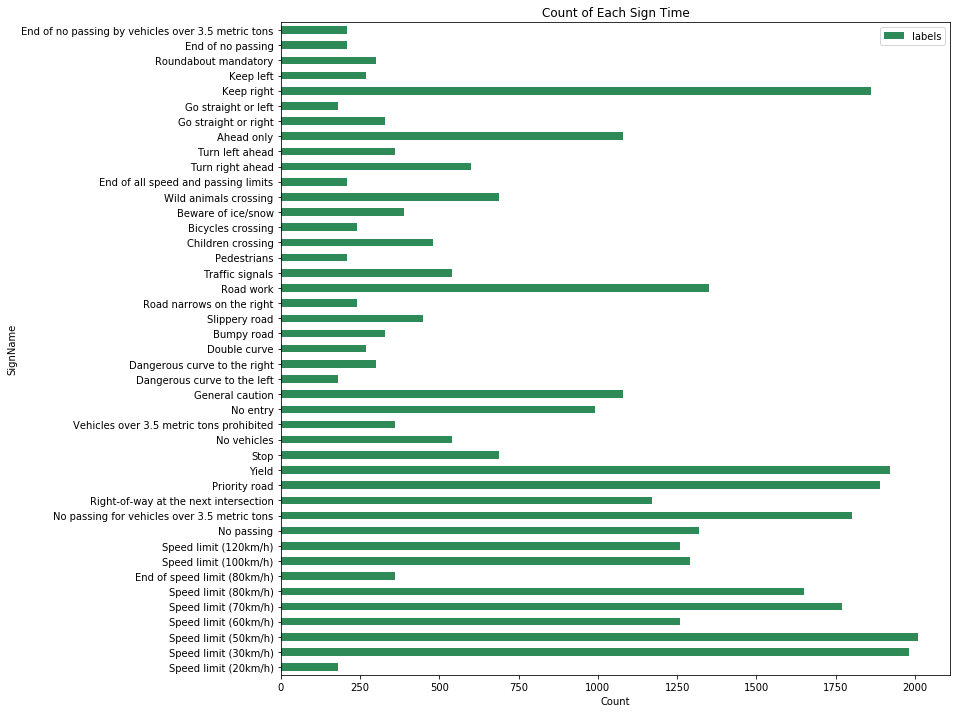

In [3]:
signnames = pd.read_csv('signnames.csv')


label_summary = pd.DataFrame(y_train, columns=['labels']).groupby('labels').labels.count()
label_summary = pd.DataFrame(label_summary).join(signnames.set_index('ClassId'))
label_summary.set_index('SignName', inplace=True)

plt.figure(figsize=(12,12))
ax = plt.gca()
label_summary.plot(kind='barh', rot=0,color='seagreen', ax=ax)
plt.title('Count of Each Sign Time')
plt.xlabel('Count')
plt.show()

The training data is far from balanaced in labels.  Thereis an order of magnitude differece in the counts of the most popular and least popular image class.  This will likely have implication for the each class accuracy.


#### Image of Each Label

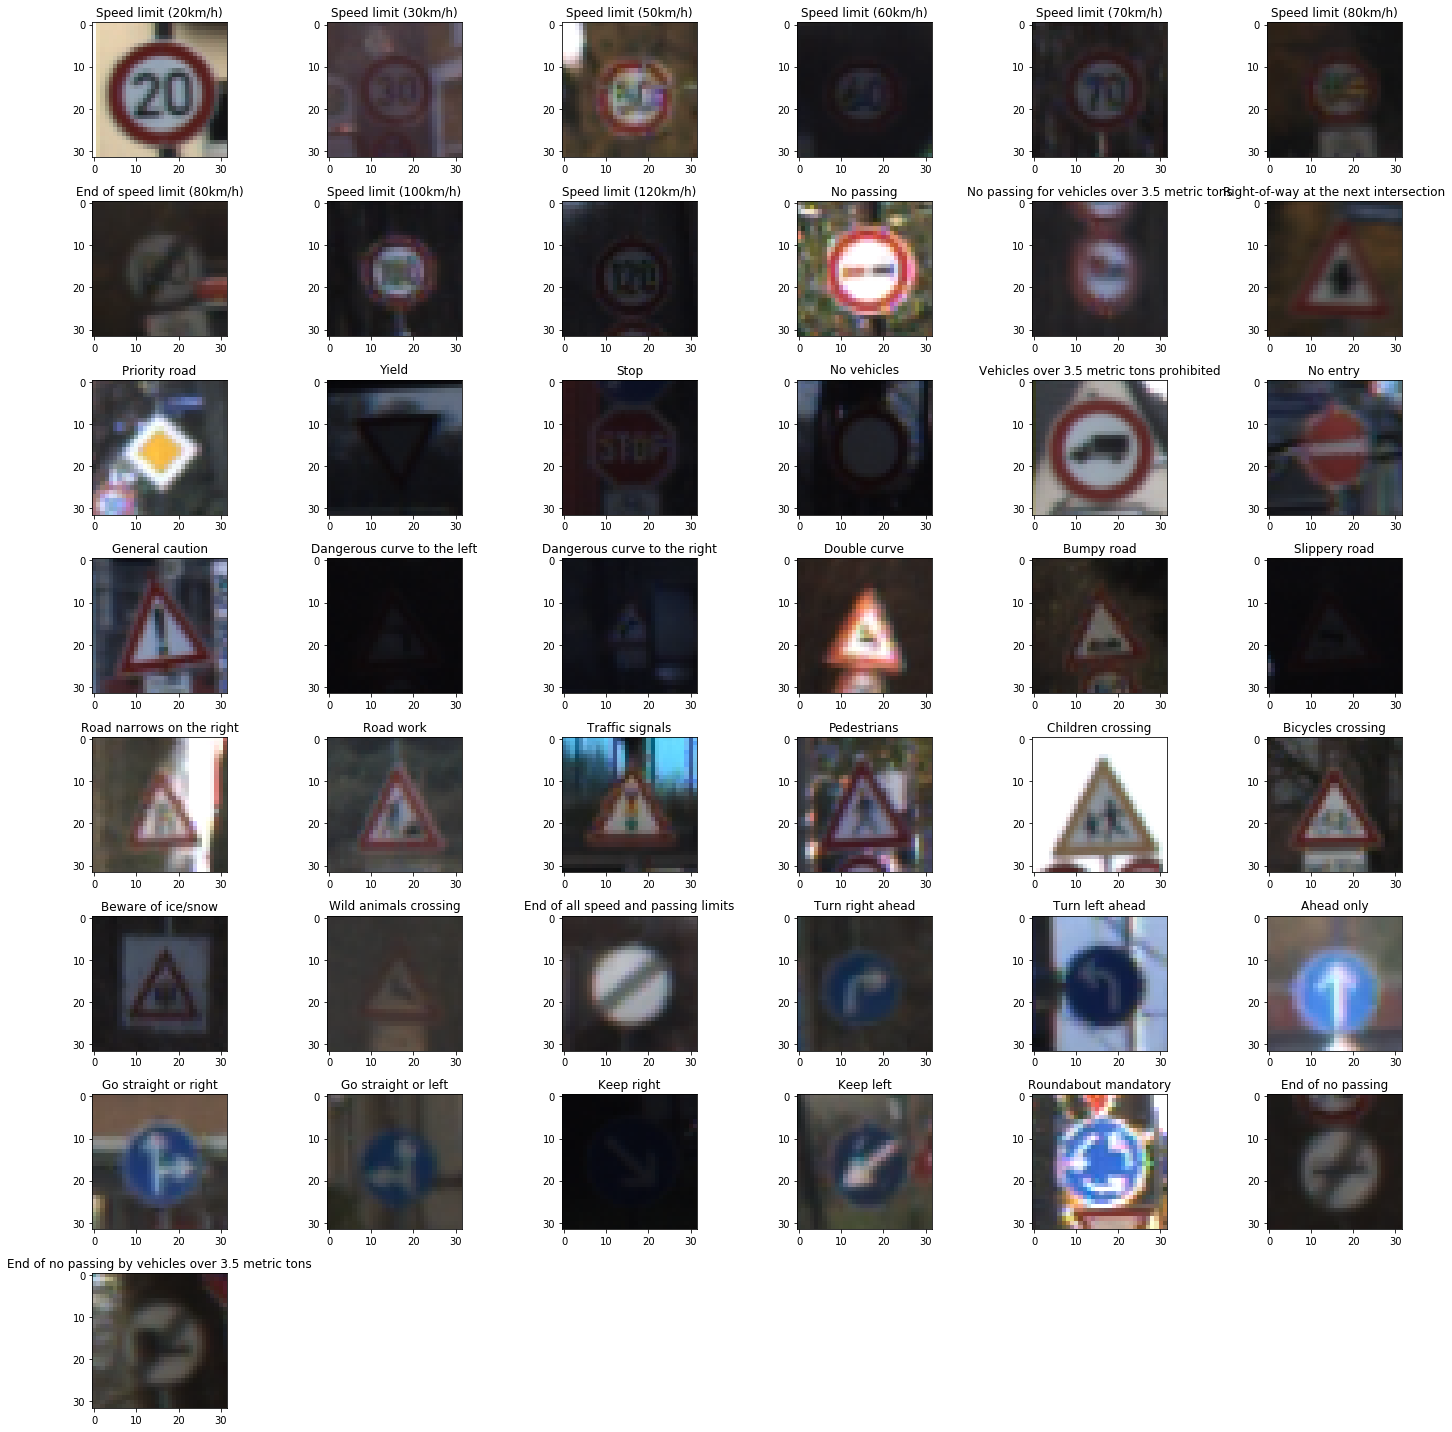

In [4]:
def plot_example(label):
    plt.imshow(X_train[np.argwhere(y_train==label)[:,0],:,:,:][0])
    plt.title(signnames.SignName[label])
  
plt.figure(figsize=(20,20))
for i in range(43):
    ax = plt.subplot(8,6,i+1)
    plot_example(i)

plt.tight_layout()
plt.show()

----

### Step 2: Design and Test a Model Architecture

The model architecture for this project is very similar to LeNet archtecture.  Instead of preprocessing images, I have included a batch-normalization layer at the beginning of the network.   I have also made each convolutional layer deeper than LeNet, whcih required the dense layers to be larger.  I also included dropout between the first and second dense layers

In [5]:
import tensorflow as tf

x = tf.placeholder(tf.float32, (None, 32, 32, 3), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
training = tf.placeholder(tf.bool, name='training')
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.0005
mu = 0
sigma = 0.1

normalized = tf.layers.batch_normalization(x, training=training)
layer_1 = tf.layers.conv2d(
    x, 16, 5, padding='VALID', 
    bias_initializer=tf.truncated_normal_initializer(mean=mu,stddev=sigma),
    activation=tf.nn.relu,
    name='layer_1'
)
pool_1 = tf.layers.max_pooling2d(inputs=layer_1, pool_size=[2, 2], strides=2)

layer_2 = tf.layers.conv2d(
    pool_1, 64, 5, padding='VALID', 
    bias_initializer=tf.truncated_normal_initializer(mean=mu,stddev=sigma),
    activation=tf.nn.relu,
    name='layer_2'
)
pool_2 = tf.layers.max_pooling2d(inputs=layer_2, pool_size=[2, 2], strides=2)
pool_2_flat = tf.reshape(pool_2, [-1, 5 * 5 * 64])

dense_1 = tf.layers.dense(inputs=pool_2_flat, units=256, activation=tf.nn.relu)
dropout_1 = tf.layers.dropout(inputs=dense_1, rate=0.3)
dense_2 = tf.layers.dense(inputs=dropout_1, units=128, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=dense_2, units=n_classes, activation=None)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

##### Helper Function for Evaluation

In [6]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, training:False})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Augment Dataset

To improve generalization, I have created random roations, sheres, shifts, and zooms on the training data.

In [10]:
def augment_data(dataset, dataset_labels, augementation_factor=3, use_random_rotation=True, use_random_shear=True, use_random_shift=True, use_random_zoom=True):
	augmented_image = []
	augmented_image_labels = []

	for num in range (0, dataset.shape[0]):

		for i in range(0, augementation_factor):
			# original image:
			augmented_image.append(dataset[num])
			augmented_image_labels.append(dataset_labels[num])

			if use_random_rotation:
				augmented_image.append(tf.contrib.keras.preprocessing.image.random_rotation(dataset[num], 30, row_axis=0, col_axis=1, channel_axis=2))
				augmented_image_labels.append(dataset_labels[num])

			if use_random_shear:
				augmented_image.append(tf.contrib.keras.preprocessing.image.random_shear(dataset[num], 0.3, row_axis=0, col_axis=1, channel_axis=2))
				augmented_image_labels.append(dataset_labels[num])

			if use_random_shift:
				augmented_image.append(tf.contrib.keras.preprocessing.image.random_shift(dataset[num], 0.2, 0.2, row_axis=0, col_axis=1, channel_axis=2))
				augmented_image_labels.append(dataset_labels[num])

			if use_random_zoom:
				augmented_image.append(tf.contrib.keras.preprocessing.image.random_zoom(dataset[num], (0.8,1.1), row_axis=0, col_axis=1, channel_axis=2))
				augmented_image_labels.append(dataset_labels[num])

	return np.array(augmented_image), np.array(augmented_image_labels)

In [11]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_aug_train, y_aug_train = augment_data(X_train, y_train)

### Train, Validate and Test the Model

In [13]:
# The augemtned data is 3 times larger so reduce epochs by ~3
EPOCHS = 31
BATCH_SIZE = 256

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_aug_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_aug_train, y_aug_train = shuffle(X_aug_train, y_aug_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_aug_train[offset:end], y_aug_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, training:True})
        
        if i % 10 == 0:
            validation_accuracy = evaluate(X_valid, y_valid)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    

Training...

EPOCH 1 ...
Validation Accuracy = 0.867

EPOCH 11 ...
Validation Accuracy = 0.959

EPOCH 21 ...
Validation Accuracy = 0.961

EPOCH 31 ...
Validation Accuracy = 0.974

Model saved


### Test Set Results

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.965


The out of sample accuracty os **96.5%**

---

### Step 3: Test a Model on New Images

I pulled 5 images using a google image search.

### Load and Output the Images

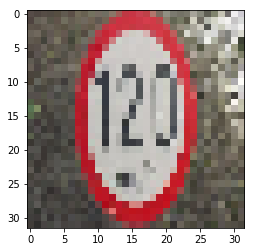

In [15]:
import cv2
def load_covnert_image(file_name):
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(32,32))
    plt.imshow(img)
    return img

X_test_2 = np.array([load_covnert_image('120kmphr.jpg')])
y_test_2 = np.array([8])

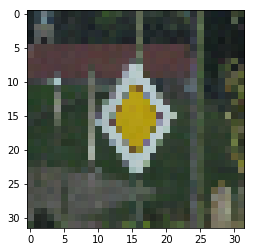

In [16]:
X_test_2 = np.append(
    X_test_2,
    np.array([load_covnert_image('priority_road.jpg')]),
    axis=0
)
y_test_2 = np.append(
    y_test_2,
    np.array([12])
)

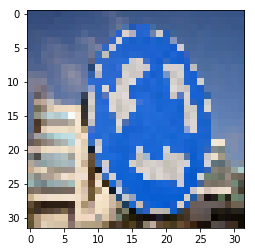

In [17]:
X_test_2 = np.append(
    X_test_2,
    np.array([load_covnert_image('roundabout.jpg')]),
    axis=0
)
y_test_2 = np.append(
    y_test_2,
    np.array([40])
)

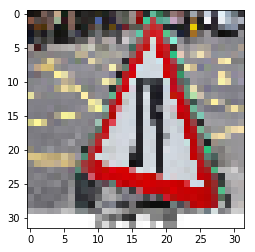

In [18]:
X_test_2 = np.append(
    X_test_2,
    np.array([load_covnert_image('road_narrows.jpg')]),
    axis=0
)
y_test_2 = np.append(
    y_test_2,
    np.array([24])
)

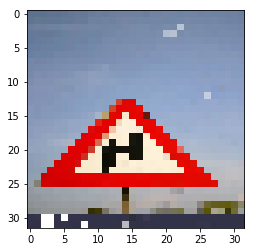

In [19]:
X_test_2 = np.append(
    X_test_2,
    np.array([load_covnert_image('double_curve.jpg')]),
    axis=0
)
y_test_2 = np.append(
    y_test_2,
    np.array([21])
)

### Predict the Sign Type for Each Image

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_2, y_test_2)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.400



The test accuracy on these images is 40% because it predicted 2 of the images correctly and 3 of them incorrectly.

### Analyze Performance

INFO:tensorflow:Restoring parameters from ./lenet


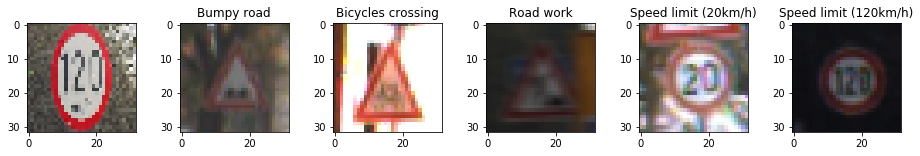

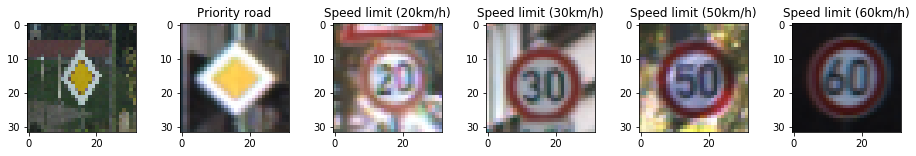

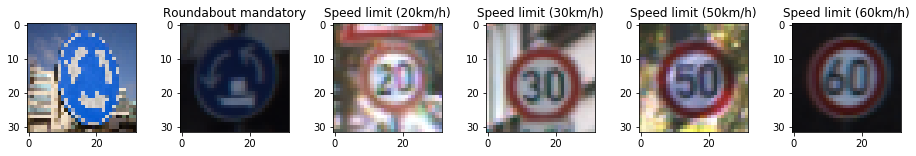

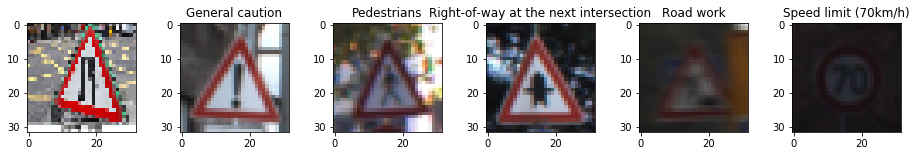

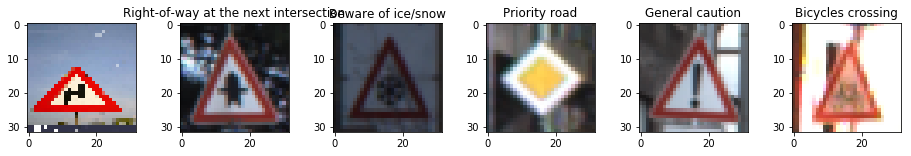

In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    probs = sess.run(
        tf.nn.top_k(tf.nn.softmax(logits), k=5),  
        feed_dict={x: X_test_2, y: y_test_2, training:False}
    )
    for j in range(len(X_test_2)):
        plt.figure(figsize=(16,2))
        ax = plt.subplot(1,6,1)
        plt.imshow(X_test_2[j])
        for i, val in enumerate(probs.indices[j]):
            ax = plt.subplot(1,6,2+i)
            plot_example(val)
        plt.show()

#### 120 mph Sign

This sign has some additional markers unders the 120 portion of the sign.   The key feauters that seem to be picked up is the red boarder, the white background, and the black features near the lower red boarder.  This has not generalized well.

#### Priority Road

This sign was labeled correctly.  The key featuers seem to be the yellow and shape.

#### Roundable mandatory

This sign was albeled correctly.  The key features eem to be the blue and shape.

#### Road Narrow.

This sign was labeled incorrectly, but it make all the guesses are reasonable considering the distortion in the resizing.  The main features seem to be the red board, white background, and black features that run the length of the middel of the sign.


#### Double Curve

This sign was labeled incorrectly, but it make all the guesses are reasonable considering the distortion in the resizing.  The main features seem to be the red board, white background, and black features clumped near the center of he sign.









### Out of Sample Performance by Label

INFO:tensorflow:Restoring parameters from ./lenet


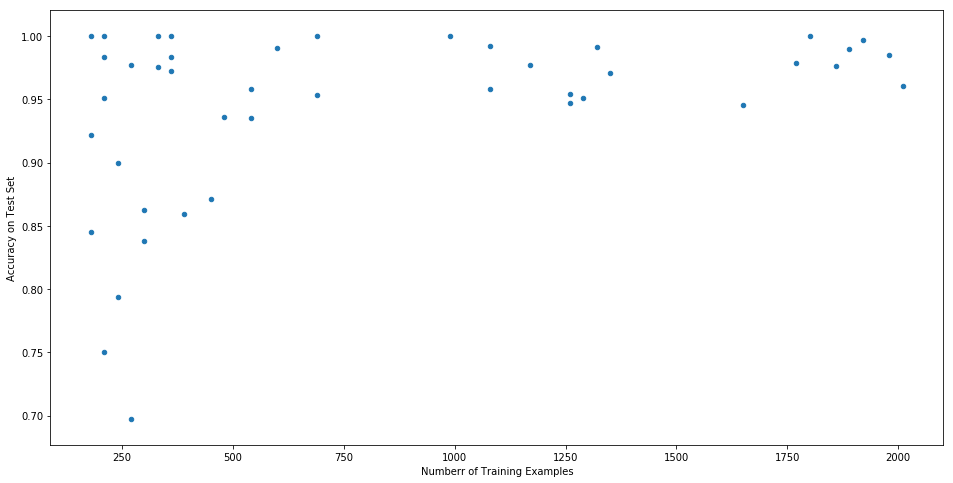

In [130]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred_y = tf.argmax(logits, 1) 
    predicted_y = pred_y.eval(session=sess,feed_dict={x: X_test, y: y_test, training:False})
    
test_results = pd.DataFrame(np.vstack([predicted_y, y_test]).T, columns=['predicted','label'])
test_results['correct'] = (test_results.predicted == test_results.label).astype(int)
test_summary = test_results.groupby('predicted').correct.agg(['mean','count'])
test_summary['train_count'] = label_summary['labels'].values

plt.figure(figsize=(16,8))
ax = plt.gca()
test_summary.plot(kind='scatter', y='mean', x='train_count', ax=ax)
plt.xlabel('Numberr of Training Examples')
plt.ylabel('Accuracy on Test Set')
plt.show()

We can see that the lack of balanced data shows that the number of training examples are related to the out of sample performance.   Address this can like improve generalization.

---

#### Step 4: Visualize the Neural Network's State with Test Images

In [29]:
def outputFeatureMap(image_input, tf_activation, session, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    #tf_activation = [v for v in tf.global_variables() if v.name == tf_activation_name][0]

    activation = tf_activation.eval(session=session,feed_dict={x : image_input})
    
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        if featuremap >= 6*8-1:
            break

#### Examine the Features for the 120 km/hr Test Image

INFO:tensorflow:Restoring parameters from ./lenet
Test Image Features


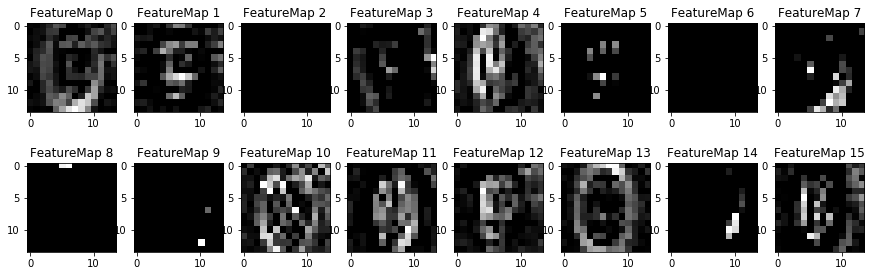

Training Image Features


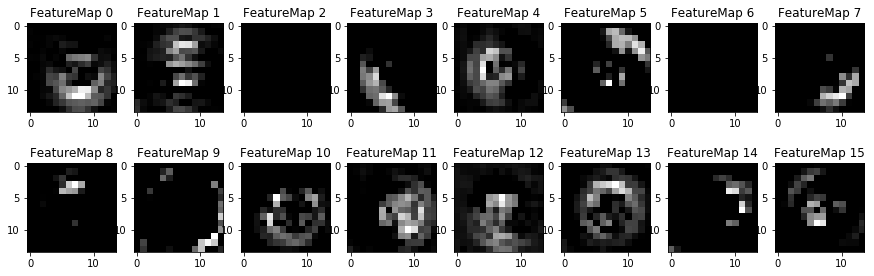

Predicted Image Features


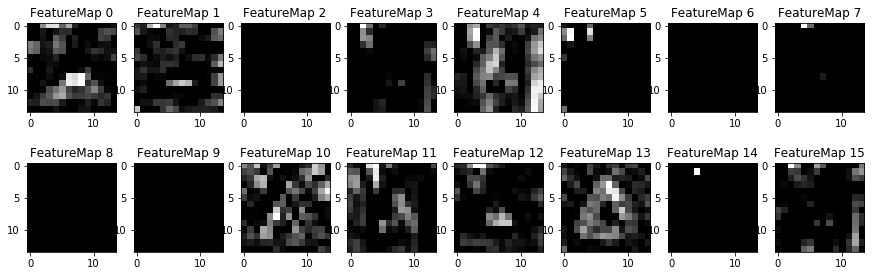

In [44]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print("Test Image Features")
    outputFeatureMap(X_test_2[:1,:,:,:],pool_1, sess)
    plt.show()
    print("Training Image Features")
    outputFeatureMap(X_train[np.argwhere(y_train==8)[:,0],:,:,:][:1],pool_1, sess)
    plt.show()
    print("Predicted Image Features")
    outputFeatureMap(X_train[np.argwhere(y_train==22)[:,0],:,:,:][:1],pool_1, sess)

To my eyes, the the first layer features of the test image look much closer to the layers_1 features of the correct training image than the final predicted label training image.  

By the time we go to the first dense layer we can see that the test images two most promiate features (in yellow) have 1 overlap with the correct labels dense features (second row).  The distributions of values in the dense layer is closer to the correct label (row 2) than the predicted label dense layer (row 3)

INFO:tensorflow:Restoring parameters from ./lenet


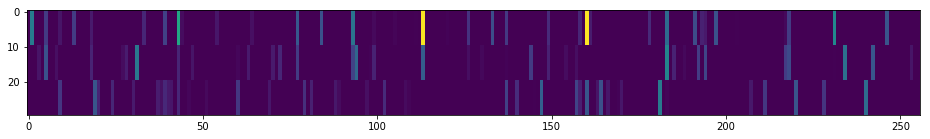

In [84]:
with tf.Session() as sess:
    
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    activation = dense_1.eval(session=sess,feed_dict={
        x : [X_test_2[0,:,:,:]]*10+[X_train[np.argwhere(y_train==8)[:,0],:,:,:][0]]*10+[X_train[np.argwhere(y_train==22)[:,0],:,:,:][0]]*10
    })
    plt.figure(figsize=(16,2))
    plt.imshow(activation)

In the second dense layer, the features for the test image are much closer to the features of the correct label than the predicted lable.  However, the two strongest features for the correct label are not features for the test image!

INFO:tensorflow:Restoring parameters from ./lenet


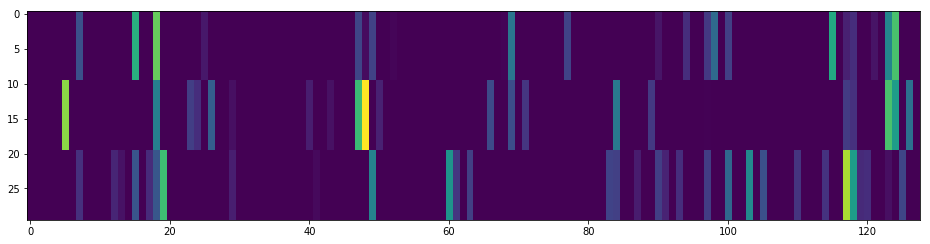

In [95]:
with tf.Session() as sess:
    
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    activation = dense_2.eval(session=sess,feed_dict={
        x : [X_test_2[0,:,:,:]]*10+[X_train[np.argwhere(y_train==8)[:,0],:,:,:][0]]*10+[X_train[np.argwhere(y_train==22)[:,0],:,:,:][0]]*10
    })
    plt.figure(figsize=(16,4))
    plt.imshow(activation)
    plt.show()

By the time we get to the logics, we can see that there is not a very strong opinion of the label for the test image, but the largest logit is for the predictve values.

INFO:tensorflow:Restoring parameters from ./lenet


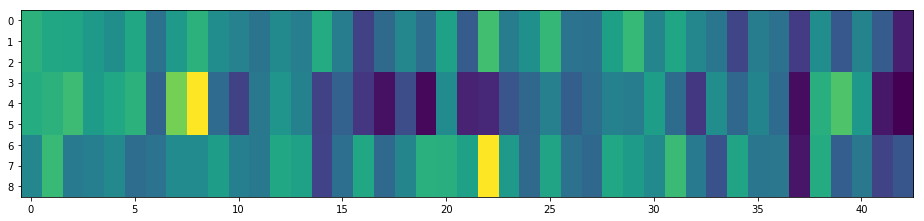

In [94]:
with tf.Session() as sess:
    
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    activation = logits.eval(session=sess,feed_dict={
        x : [X_test_2[0,:,:,:]]*3+[X_train[np.argwhere(y_train==8)[:,0],:,:,:][0]]*3+[X_train[np.argwhere(y_train==22)[:,0],:,:,:][0]]*3
    })
    plt.figure(figsize=(16,16))
    plt.imshow(activation)

# Conclusion

In this report I modified the LeNet Architecture to include batch-normalization, make the convolutional layers larger, and include dropout between the dense layer to achieve a 96.5% percent accuracy on the test set.  I was also able to see that the lack of balance training data resulted in less reliable generalization on examples with fewer examples.   

I was also able to visualize the different layers of the networks for one of the test images and show how the test and training example diverge through the inference process to result in miss labeling images.